# MCMC: comparison of various algorithms

This script illustrates performance of various MCMC algorithms currently integrated in UQpy:
- Metropolis Hastings (MH)
- Modified Metropolis Hastings (MMH)
- Affine Invariant with Stretch moves (Stretch)
- Adaptive Metropolis with delayed rejection (DRAM)
- DE-MC

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.stats import multivariate_normal, uniform

from UQpy.SampleMethods import MCMC, MCMC_v2
from UQpy.Distributions import Distribution

## Affine invariant with Stretch moves

This algorithm requires as seed a few samples near the region of interest. Here MH is first run to obtain few samples, used as seed within the Stretch algorithm.

In [2]:
def log_Rosenbrock(x):
     return (-(100*(x[:, 1]-x[:, 0]**2)**2+(1-x[:, 0])**2)/20)

(50, 2)


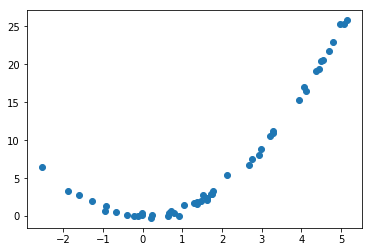

In [3]:
x = MCMC_v2(dimension=2, algorithm='MH', nburn=500, jump=1000, nsamples=50, seed=None, 
            proposal_type='normal', proposal_scale=[1.,1.], 
            log_pdf_target=log_Rosenbrock)
print(x.samples.shape)
plt.plot(x.samples[:,0], x.samples[:,1], 'o')
plt.show()

(2500, 2)


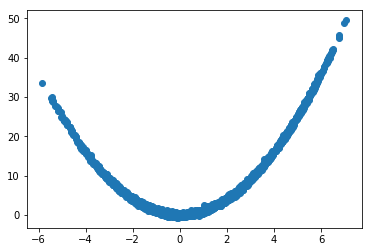

In [19]:
x = MCMC_v2(dimension=2, algorithm='Stretch', nburn=0, jump=100, nsamples=50,
            log_pdf_target=log_Rosenbrock, pdf_target_params=None,
            seed=x.samples, scale=2.)
print(x.samples.shape)
plt.plot(x.samples[:,0],x.samples[:,1],'o')
plt.show()

## DE-MC algorithm

Performance of this algorithm is illustrated on a bimodal target pdf.

In [3]:
# Define log_pdf_target
means = [np.array([10, 1]), np.array([-5, 0])]
covs = [np.array([[1, 0.02], [0.02, 0.2]]), np.array([[1, -0.02], [-0.02, 0.2]])]
def log_pdf_bimodal(x):
    return np.log(0.4*multivariate_normal.pdf(x, mean=means[0], cov=covs[0]) + \
                  0.6*multivariate_normal.pdf(x, mean=means[1], cov=covs[1]))

# Define a function to sample seed uniformly distributed in the 2d space ([-20, 20], [-4, 4])
prior_sample = lambda nsamples: np.array([[-2, -2]]) + np.array([[4, 4]]) * Distribution(
    dist_name=['uniform', 'uniform']).rvs(params=[[0, 1], [0, 1]], nsamples=nsamples)

/Users/audreyolivier/Documents/JHU_Research/UQpy/src/UQpy/SampleMethods.py:2904: UserWarning: Input proposal_type not used in DE-MC algorithm (used inputs are "gamma").
  warnings.warn('Input ' + key + ' not used in DE-MC algorithm (used inputs are "gamma").')
/Users/audreyolivier/Documents/JHU_Research/UQpy/src/UQpy/SampleMethods.py:2904: UserWarning: Input proposal_scale not used in DE-MC algorithm (used inputs are "gamma").
  warnings.warn('Input ' + key + ' not used in DE-MC algorithm (used inputs are "gamma").')


[[-1.76462838  1.67362281]
 [ 0.43551066 -1.61763769]
 [ 0.95403985 -1.54214225]
 [ 1.89495376 -1.48915863]]
[[-0.02789038  1.82651592]
 [-3.91939316  2.14607305]
 [-3.40086198  2.22156763]
 [ 4.51311894 -5.40575902]]
False
False
False
False
[[-1.76462838  1.67362281]
 [ 0.43551066 -1.61763769]
 [ 0.95403985 -1.54214225]
 [ 1.89495376 -1.48915863]]
[[-0.02788951  1.8265123 ]
 [-2.79970371  2.20912254]
 [-0.78269706 -1.69503087]
 [-1.34026172  2.33760318]]
False
False
True
True
[[-1.76462838  1.67362281]
 [ 0.43551066 -1.61763769]
 [-0.78269706 -1.69503087]
 [-1.34026172  2.33760318]]
[[-2.9828356   1.59622981]
 [ 0.85987643 -0.95365596]
 [-0.35832861 -1.03105091]
 [-0.35833027 -1.03105109]]
False
True
True
False
[[-1.76462838  1.67362281]
 [ 0.85987643 -0.95365596]
 [-0.35832861 -1.03105091]
 [-1.34026172  2.33760318]]
[[-2.93312766  5.68231908]
 [ 2.02837722 -4.96235531]
 [-2.97649376  2.88554621]
 [-2.78992509  2.24550175]]
False
False
False
False
[[-1.76462838  1.67362281]
 [ 0.8598

False
[[-2.80256905  7.73334754]
 [ 0.09913171  0.24044093]
 [-0.92046239  0.26650121]
 [ 0.18838901  0.23816016]]
[[-1.69371677  7.70500626]
 [ 3.09008955 -7.25474774]
 [ 1.9812396  -7.22640468]
 [ 1.20798318  0.21210026]]
False
False
False
False
[[-2.80256905  7.73334754]
 [ 0.09913171  0.24044093]
 [-0.92046239  0.26650121]
 [ 0.18838901  0.23816016]]
[[-1.58925179  7.70233473]
 [-2.14057385  9.12598673]
 [-4.37348586  9.18305884]
 [-3.26463435  9.15471786]]
False
False
False
False
[[-2.80256905  7.73334754]
 [ 0.09913171  0.24044093]
 [-0.92046239  0.26650121]
 [ 0.18838901  0.23816016]]
[[-4.12210421  7.76707305]
 [ 2.33883968 -8.64510742]
 [ 2.63877807 -8.6527733 ]
 [-2.05131928  9.12370797]]
False
False
False
False
[[-2.80256905  7.73334754]
 [ 0.09913171  0.24044093]
 [-0.92046239  0.26650121]
 [ 0.18838901  0.23816016]]
[[-1.78297682  7.7072863 ]
 [ 1.981238   -7.22640679]
 [-1.00971899  0.26878158]
 [ 1.20798329  0.21210044]]
False
False
True
False
[[-2.80256905  7.73334754]


 [-0.48684954  0.2576501 ]]
[[-4.25254112  7.77342551]
 [-4.30971097  9.18317737]
 [-2.43345988  9.13111621]
 [ 0.5326663   0.22936332]]
False
False
False
True
[[-2.78210084  7.73264535]
 [-0.10792281  0.24715283]
 [ 0.74881352  0.2233812 ]
 [ 0.5326663   0.22936332]]
[[-1.76258531  7.70435794]
 [ 3.83664915 -8.68175242]
 [ 4.69338525 -8.70552481]
 [-2.6496067   9.13709938]]
False
False
False
False
[[-2.78210084  7.73264535]
 [-0.10792281  0.24715283]
 [ 0.74881352  0.2233812 ]
 [ 0.5326663   0.22936332]]
[[-2.52488404  7.72552748]
 [ 3.83665235 -8.68175272]
 [-0.01348825  0.24455018]
 [ 1.55218046  0.2010748 ]]
False
False
True
False
[[-2.78210084  7.73264535]
 [-0.10792281  0.24715283]
 [-0.01348825  0.24455018]
 [ 0.5326663   0.22936332]]
[[-2.01980076  7.71147698]
 [-4.05249495  9.17605787]
 [-0.7757871   0.26571874]
 [-2.64960568  9.13709925]]
False
False
True
False
[[-2.78210084  7.73264535]
 [-0.10792281  0.24715283]
 [-0.7757871   0.26571874]
 [ 0.5326663   0.22936332]]
[[-2.01

False
True
[[-1.88353704  3.62664788]
 [-1.8516562   3.59330729]
 [-1.97402489  3.90706198]
 [-0.62484     0.55643136]]
[[-0.42362581  0.01276458]
 [-0.35380742 -0.06024844]
 [-0.51411361  0.29318042]
 [-0.66277932  0.59610627]]
True
True
True
True
[[-0.42362581  0.01276458]
 [-0.35380742 -0.06024844]
 [-0.51411361  0.29318042]
 [-0.66277932  0.59610627]]
[[-0.79130185  0.79382611]
 [-0.63840015  0.63392817]
 [-0.43102994  0.206297  ]
 [-0.57969442  0.50922041]]
True
True
True
True
[[-0.79130185  0.79382611]
 [-0.63840015  0.63392817]
 [-0.43102994  0.206297  ]
 [-0.57969442  0.50922041]]
[[-0.72144286  0.64542289]
 [-0.89021234  0.97260958]
 [-0.68284225  0.54497992]
 [-0.15097125 -0.18993864]]
True
True
True
True
[[-0.72144286  0.64542289]
 [-0.89021234  0.97260958]
 [-0.68284225  0.54497992]
 [-0.15097125 -0.18993864]]
[[-0.96821248  1.1543017 ]
 [-1.52313931  1.84716252]
 [-0.48200656  0.15562698]
 [-0.39774156  0.31894073]]
True
False
True
True
[[-0.96821248  1.1543017 ]
 [-0.8902

False
True
[[-0.5439025   0.57692063]
 [-1.8946874   3.31888223]
 [-0.42868096  0.34306595]
 [ 1.37316932  2.28020693]]
[[ 3.34484686 -0.65910252]
 [ 0.38662666  5.34579129]
 [ 1.17875315 -2.91986876]
 [ 3.117717   -1.26101518]]
False
False
False
False
[[-0.5439025   0.57692063]
 [-1.8946874   3.31888223]
 [-0.42868096  0.34306595]
 [ 1.37316932  2.28020693]]
[[-2.34575175 -1.36022116]
 [ 0.0223829   5.02216922]
 [ 2.839175   -0.69561042]
 [-0.09283737  5.25602381]]
False
False
False
False
[[-0.5439025   0.57692063]
 [-1.8946874   3.31888223]
 [-0.42868096  0.34306595]
 [ 1.37316932  2.28020693]]
[[-4.43265539  1.81294516]
 [-4.03889037  1.01368551]
 [-4.3174283   1.57908984]
 [ 3.11771551 -1.26101463]]
False
False
False
False
[[-0.5439025   0.57692063]
 [-1.8946874   3.31888223]
 [-0.42868096  0.34306595]
 [ 1.37316932  2.28020693]]
[[ 3.34484746 -0.6591047 ]
 [ 0.24951399  5.62408001]
 [-2.03611325  3.60599901]
 [ 3.11771568 -1.2610146 ]]
False
False
False
False
[[-0.5439025   0.5769

False
False
False
[[ 2.3927636   4.71045436]
 [-1.48334157  2.48402089]
 [ 2.42953184  5.9726279 ]
 [ 2.90706643  9.02271016]]
[[-2.83182201 -3.07058572]
 [-0.91507457  6.11361882]
 [ 3.04155141 11.10421184]
 [-1.74925363  4.87126861]]
False
False
False
False
[[ 2.3927636   4.71045436]
 [-1.48334157  2.48402089]
 [ 2.42953184  5.9726279 ]
 [ 2.90706643  9.02271016]]
[[ 7.61734831 12.49149411]
 [-1.52709553  0.9820345 ]
 [ 1.81751187  0.84104297]
 [ 7.51963108 11.67216599]]
False
False
False
False
[[ 2.3927636   4.71045436]
 [-1.48334157  2.48402089]
 [ 2.42953184  5.9726279 ]
 [ 2.90706643  9.02271016]]
[[ 7.61734915 12.49149468]
 [-1.43958933  3.98600733]
 [ 1.81751228  0.84104344]
 [ 7.56338641 13.17415471]]
False
False
False
False
[[ 2.3927636   4.71045436]
 [-1.48334157  2.48402089]
 [ 2.42953184  5.9726279 ]
 [ 2.90706643  9.02271016]]
[[-2.8318213  -3.07058637]
 [-0.87132203  7.61560601]
 [-2.79505303 -1.80841305]
 [ 2.95081919 10.52469687]]
False
False
False
False
[[ 2.3927636  

True
False
False
[[-0.36033836  0.01179088]
 [-0.80241155  0.46976367]
 [ 2.38052564  5.9226325 ]
 [ 2.38616326  5.91872144]]
[[ 3.42735874  6.50070556]
 [-4.06403971 -6.56413946]
 [ 2.90659228  5.37764577]
 [-1.40153157 -0.57019375]]
False
False
False
False
[[-0.36033836  0.01179088]
 [-0.80241155  0.46976367]
 [ 2.38052564  5.9226325 ]
 [ 2.38616326  5.91872144]]
[[-4.15474282 -6.4724684 ]
 [-4.07074916 -6.55948434]
 [-0.88781221 -1.1066145 ]
 [-1.40153265 -0.57019363]]
False
False
False
False
[[-0.36033836  0.01179088]
 [-0.80241155  0.46976367]
 [ 2.38052564  5.9226325 ]
 [ 2.38616326  5.91872144]]
[[ 3.43406461  6.49605095]
 [-4.07074817 -6.55948354]
 [ 5.64886349 12.95187846]
 [ 1.86009491  6.46370804]]
False
False
False
False
[[-0.36033836  0.01179088]
 [-0.80241155  0.46976367]
 [ 2.38052564  5.9226325 ]
 [ 2.38616326  5.91872144]]
[[ 3.43406611  6.49605012]
 [ 2.4592159   7.50366449]
 [-1.41387788 -0.56162682]
 [-0.87546611 -1.11518092]]
False
False
False
False
[[-0.36033836  

 [-1.35569571  2.08929843]]
[[-3.21731089  1.9652606 ]
 [ 2.96292613 -0.88624487]
 [-1.39022469  3.15702575]
 [ 0.38193338  2.46834458]]
False
False
False
False
[[-0.70313292  0.74715169]
 [ 0.44874647  0.33186307]
 [ 0.75706002  1.06567788]
 [-1.35569571  2.08929843]]
[[ 1.81104597 -0.47095519]
 [ 2.96292766 -0.8862451 ]
 [-1.39022521  3.15702563]
 [ 0.38193267  2.4683458 ]]
False
False
False
False
[[-0.70313292  0.74715169]
 [ 0.44874647  0.33186307]
 [ 0.75706002  1.06567788]
 [-1.35569571  2.08929843]]
[[-0.33623951  1.62039093]
 [-1.28888108 -0.04718286]
 [-0.01948902  2.66283215]
 [-2.72643225  2.58349273]]
False
False
False
False
[[-0.70313292  0.74715169]
 [ 0.44874647  0.33186307]
 [ 0.75706002  1.06567788]
 [-1.35569571  2.08929843]]
[[-0.33623954  1.6203921 ]
 [ 2.96292584 -0.88624651]
 [ 2.12779711  0.57148405]
 [ 0.01504168  1.59510367]]
False
False
False
False
[[-0.70313292  0.74715169]
 [ 0.44874647  0.33186307]
 [ 0.75706002  1.06567788]
 [-1.35569571  2.08929843]]
[[-3

 [-1.35569571  2.08929843]]
[[ 1.81104631 -0.4709557 ]
 [ 2.96292518 -0.88624521]
 [-0.01949054  2.66283113]
 [-0.98880303  2.96254051]]
False
False
False
False
[[-0.70313292  0.74715169]
 [ 0.44874647  0.33186307]
 [ 0.75706002  1.06567788]
 [-1.35569571  2.08929843]]
[[-3.21730995  1.96526003]
 [-0.32780477  1.92901666]
 [-0.61367598  1.55987158]
 [-2.72643256  2.58349222]]
False
False
False
False
[[-0.70313292  0.74715169]
 [ 0.44874647  0.33186307]
 [ 0.75706002  1.06567788]
 [-1.35569571  2.08929843]]
[[-0.39481918  1.48096491]
 [-1.0114482   0.01333585]
 [ 0.10449693  2.40782486]
 [-0.20381606  1.67400948]]
False
False
False
False
[[-0.70313292  0.74715169]
 [ 0.44874647  0.33186307]
 [ 0.75706002  1.06567788]
 [-1.35569571  2.08929843]]
[[-1.07002643 -0.12608706]
 [-0.3278032   1.92901758]
 [-0.61367426  1.55987016]
 [-1.72258875  1.2160589 ]]
False
False
False
False
[[-0.70313292  0.74715169]
 [ 0.44874647  0.33186307]
 [ 0.75706002  1.06567788]
 [-1.35569571  2.08929843]]
[[ 1

False
False
False
[[-0.70313292  0.74715169]
 [ 0.44874647  0.33186307]
 [ 0.75706002  1.06567788]
 [-1.35569571  2.08929843]]
[[-1.07002654 -0.12608926]
 [-0.32780578  1.92901768]
 [-1.39022688  3.15702632]
 [ 0.01504137  1.59510484]]
False
False
False
False
[[-0.70313292  0.74715169]
 [ 0.44874647  0.33186307]
 [ 0.75706002  1.06567788]
 [-1.35569571  2.08929843]]
[[ 1.81104556 -0.47095747]
 [ 2.96292667 -0.88624566]
 [-0.6136771   1.55987007]
 [ 0.01504119  1.59510601]]
False
False
False
False
[[-0.70313292  0.74715169]
 [ 0.44874647  0.33186307]
 [ 0.75706002  1.06567788]
 [-1.35569571  2.08929843]]
[[-1.07002549 -0.12608843]
 [-1.2888825  -0.04718403]
 [ 1.5336093  -0.53147502]
 [-3.09332792  1.71025196]]
False
False
False
False
[[-0.70313292  0.74715169]
 [ 0.44874647  0.33186307]
 [ 0.75706002  1.06567788]
 [-1.35569571  2.08929843]]
[[-3.2173112   1.96526002]
 [ 1.22529521 -1.2652901 ]
 [-1.39022613  3.15702733]
 [-2.72643165  2.58349333]]
False
False
False
False
[[-0.70313292 

 [-1.35569571  2.08929843]]
[[-3.2173121   1.96526081]
 [ 2.1863753   0.71090941]
 [ 1.53361002 -0.53147669]
 [-1.72258946  1.21605751]]
False
False
False
False
[[-0.70313292  0.74715169]
 [ 0.44874647  0.33186307]
 [ 0.75706002  1.06567788]
 [-1.35569571  2.08929843]]
[[-3.21731354  1.96525968]
 [ 2.18637593  0.71091002]
 [ 1.53361001 -0.53147588]
 [-3.09332367  1.71025321]]
False
False
False
False
[[-0.70313292  0.74715169]
 [ 0.44874647  0.33186307]
 [ 0.75706002  1.06567788]
 [-1.35569571  2.08929843]]
[[ 1.4441533  -1.34419575]
 [ 2.18637626  0.71090931]
 [ 2.12779625  0.57148319]
 [-3.09332467  1.71025273]]
False
False
False
False
[[-0.70313292  0.74715169]
 [ 0.44874647  0.33186307]
 [ 0.75706002  1.06567788]
 [-1.35569571  2.08929843]]
[[-3.21731257  1.96526003]
 [-0.32780451  1.92901752]
 [-0.01949155  2.66283153]
 [-0.98880198  2.96253661]]
False
False
False
False
[[-0.70313292  0.74715169]
 [ 0.44874647  0.33186307]
 [ 0.75706002  1.06567788]
 [-1.35569571  2.08929843]]
[[-1

False
False
[[ 0.97465402  1.01586543]
 [-0.0114516  -0.09876851]
 [ 0.96994398  1.04007709]
 [-1.58299578  1.85957744]]
[[ 4.01264999  0.04065911]
 [-0.00584556 -0.12757871]
 [-0.20352151 -0.28633722]
 [-1.57738929  1.83076622]]
False
True
False
True
[[ 0.97465402  1.01586543]
 [-0.00584556 -0.12757871]
 [ 0.96994398  1.04007709]
 [-1.57738929  1.83076622]]
[[-0.89548475  3.34629748]
 [ 3.03108644 -1.09731029]
 [ 2.13673798  2.40077736]
 [-2.74418193  0.47006604]]
False
False
False
False
[[ 0.97465402  1.01586543]
 [-0.00584556 -0.12757871]
 [ 0.96994398  1.04007709]
 [-1.57738929  1.83076622]]
[[-2.05667211  1.95678631]
 [ 3.0254803  -1.06849859]
 [-0.19684978 -0.32062138]
 [-0.41059399  3.19146408]]
False
False
True
False
[[ 0.97465402  1.01586543]
 [-0.00584556 -0.12757871]
 [-0.19684978 -0.32062138]
 [-1.57738929  1.83076622]]
[[ 1.20194791  1.24558639]
 [ 3.03108664 -1.09731185]
 [ 2.84008281 -1.29035321]
 [-2.97147898  0.24034737]]
True
False
False
False
[[ 1.20194791  1.2455863

 [-1.66113811  3.94234211]]
False
False
False
False
[[ 1.95350727  3.37631067]
 [ 1.78263264  2.89745104]
 [ 1.46182743  1.99844752]
 [-1.86447898  3.37249877]]
[[ 6.29357139  2.81100506]
 [ 5.74093798  1.26232972]
 [ 1.25848605  1.42860633]
 [-2.44957801  1.73284236]]
False
False
True
False
[[ 1.95350727  3.37631067]
 [ 1.78263264  2.89745104]
 [ 1.25848605  1.42860633]
 [-1.86447898  3.37249877]]
[[ 5.66983489  1.06307742]
 [ 6.32603794  2.90198753]
 [ 1.46182854  1.99844998]
 [-2.06782059  2.80265422]]
False
False
True
False
[[ 1.95350727  3.37631067]
 [ 1.78263264  2.89745104]
 [ 1.46182854  1.99844998]
 [-1.86447898  3.37249877]]
[[-2.38655744  3.94161715]
 [-2.17567296  4.53256892]
 [-3.08157608  1.99391446]
 [-2.24623783  2.3026864 ]]
False
True
False
False
[[ 1.95350727  3.37631067]
 [-2.17567296  4.53256892]
 [ 1.46182854  1.99844998]
 [-1.86447898  3.37249877]]
[[5.59101056 0.84219094]
 [1.64231397 4.53637989]
 [1.77302303 0.8383801 ]
 [2.26470116 2.21624063]]
False
False
Fal

False
[[-0.67977067  0.45644752]
 [ 1.22744483  1.63794403]
 [ 1.35827615  2.01371068]
 [-0.50335535  0.14188902]]
[[ 1.53557127  2.68391431]
 [ 3.44278532  3.86541191]
 [ 1.14834179  2.38803555]
 [-0.34766701  0.58905248]]
False
False
False
True
[[-0.67977067  0.45644752]
 [ 1.22744483  1.63794403]
 [ 1.35827615  2.01371068]
 [-0.34766701  0.58905248]]
[[-2.55415354 -0.79173512]
 [-0.80262647 -0.05739919]
 [-0.91130925  0.6077282 ]
 [ 1.92191913  1.99503273]]
False
False
False
False
[[-0.67977067  0.45644752]
 [ 1.22744483  1.63794403]
 [ 1.35827615  2.01371068]
 [-0.34766701  0.58905248]]
[[-0.52408225  0.9036086 ]
 [-1.19783136 -0.21519948]
 [ 3.23265991  3.26189138]
 [-0.19197723  1.03621559]]
False
False
False
False
[[-0.67977067  0.45644752]
 [ 1.22744483  1.63794403]
 [ 1.35827615  2.01371068]
 [-0.34766701  0.58905248]]
[[ 1.35030469  2.15179102]
 [ 0.83224039  1.48014379]
 [ 3.23265715  3.26189064]
 [-2.61725325 -0.81692986]]
True
False
False
False
[[ 1.35030469  2.15179102]
 

 [-0.46294656  0.19976214]]
[[ 1.80943228  5.43772551]
 [-1.09464574 -0.01959515]
 [ 3.43446417  6.86035208]
 [ 0.13928946  0.41319314]]
False
False
False
True
[[ 2.41166953  5.65115625]
 [-0.30787603  0.23094745]
 [ 0.1982053   0.41030221]
 [ 0.13928946  0.41319314]]
[[ 1.8094314   5.43772389]
 [-0.37798654  0.2343872 ]
 [-3.03805459 -6.03974799]
 [ 3.37554789  6.86324352]]
False
True
False
False
[[ 2.41166953  5.65115625]
 [-0.37798654  0.2343872 ]
 [ 0.1982053   0.41030221]
 [ 0.13928946  0.41319314]]
[[ 2.48178007  5.64771512]
 [-3.08211756 -5.99879024]
 [-0.4173555   0.19752514]
 [-2.49473293 -5.82342132]]
False
False
True
False
[[ 2.41166953  5.65115625]
 [-0.37798654  0.2343872 ]
 [-0.4173555   0.19752514]
 [ 0.13928946  0.41319314]]
[[1.79610902 5.43837722]
 [2.32614556 6.46756484]
 [2.90233589 6.64348069]
 [0.18613897 0.4570581 ]]
False
False
False
True
[[ 2.41166953  5.65115625]
 [-0.37798654  0.2343872 ]
 [-0.4173555   0.19752514]
 [ 0.18613897  0.4570581 ]]
[[ 2.36482101  5

 [1.7448919  2.54652351]]
[[ 2.51815001  6.62679617]
 [ 3.35378775 11.59044041]
 [ 2.02810378  4.05833024]
 [ 1.36447803  0.4524213 ]]
False
True
True
False
[[ 1.93679694  3.85148724]
 [ 3.35378775 11.59044041]
 [ 2.02810378  4.05833024]
 [ 1.7448919   2.54652351]]
[[ 0.02220966 -6.9107734 ]
 [ 3.58215723 13.14334777]
 [ 3.71431966 13.26768401]
 [ 3.32245556 11.50973498]]
False
True
False
True
[[ 1.93679694  3.85148724]
 [ 3.58215723 13.14334777]
 [ 2.02810378  4.05833024]
 [ 3.32245556 11.50973498]]
[[ 3.78612066 14.66265727]
 [ 3.69081304 13.38949051]
 [ 1.7190596   2.11433098]
 [ 5.2804338  22.56704923]]
False
True
False
False
[[ 1.93679694  3.85148724]
 [ 3.69081304 13.38949051]
 [ 2.02810378  4.05833024]
 [ 3.32245556 11.50973498]]
[[ 3.23114897 11.30289158]
 [ 3.59950551 13.18264843]
 [ 0.64244404 -3.59991658]
 [ 4.98516411 20.84089564]]
False
True
False
False
[[ 1.93679694  3.85148724]
 [ 3.59950551 13.18264843]
 [ 2.02810378  4.05833024]
 [ 3.32245556 11.50973498]]
[[ 2.2664868

 [-0.18501203 -0.11569019]]
[[-0.98727627  0.81956381]
 [ 0.86580968  3.47288176]
 [-1.02549528  0.64013335]
 [ 1.66807384  2.53762658]]
True
False
True
True
[[-0.98727627  0.81956381]
 [ 1.68718236  2.62734192]
 [-1.02549528  0.64013335]
 [ 1.66807384  2.53762658]]
[[-1.01001555  0.71280382]
 [ 4.8925307   4.88535897]
 [-4.18536127 -1.40436037]
 [ 4.89615978  4.90240509]]
False
False
False
False
[[-0.98727627  0.81956381]
 [ 1.68718236  2.62734192]
 [-1.02549528  0.64013335]
 [ 1.66807384  2.53762658]]
[[-0.96453728  0.92632382]
 [-1.47268284  0.58284797]
 [ 2.13437202  2.68462826]
 [ 1.6225929   2.32410433]]
True
False
False
True
[[-0.96453728  0.92632382]
 [ 1.68718236  2.62734192]
 [-1.02549528  0.64013335]
 [ 1.6225929   2.32410433]]
[[-1.04139727  0.56547148]
 [ 1.61464167  2.28677644]
 [ 2.05318766  2.30349227]
 [ 1.55005271  1.98353941]]
False
True
False
False
[[-0.96453728  0.92632382]
 [ 1.61464167  2.28677644]
 [-1.02549528  0.64013335]
 [ 1.6225929   2.32410433]]
[[ 2.18668

 [-0.65546329  0.51106932]]
[[-1.15253623  1.05233829]
 [-1.64718784  0.25415216]
 [ 1.32063499  2.18242403]
 [ 1.98173922  1.46253819]]
True
False
True
False
[[-1.15253623  1.05233829]
 [ 1.25879897  1.63933773]
 [ 1.32063499  2.18242403]
 [-0.65546329  0.51106932]]
[[-1.0789506   1.69861123]
 [-1.0927573  -0.34957567]
 [ 3.59860669  3.52506425]
 [ 2.21402668  1.20959869]]
False
False
False
False
[[-1.15253623  1.05233829]
 [ 1.25879897  1.63933773]
 [ 1.32063499  2.18242403]
 [-0.65546329  0.51106932]]
[[-3.50409495 -0.93657472]
 [ 1.85031642  0.99522516]
 [-1.54885345  1.48389403]
 [-0.72904852 -0.13520319]]
False
False
False
True
[[-1.15253623  1.05233829]
 [ 1.25879897  1.63933773]
 [ 1.32063499  2.18242403]
 [-0.72904852 -0.13520319]]
[[-3.51807492 -1.05936325]
 [-1.68427734  0.29453539]
 [ 3.68617386  4.29412749]
 [-3.59853677 -0.83373274]]
False
False
False
False
[[-1.15253623  1.05233829]
 [ 1.25879897  1.63933773]
 [ 1.32063499  2.18242403]
 [-0.72904852 -0.13520319]]
[[ 1.28

False
False
False
[[ 1.35929983  1.73432648]
 [ 4.51667315 20.02309547]
 [ 3.85030825 14.82228851]
 [ 1.53492715  2.31469283]]
[[ -2.18897722 -19.33867182]
 [  7.48097406  35.59777034]
 [  0.30203087  -6.25071129]
 [ -2.2223497  -19.44894192]]
False
False
False
False
[[ 1.35929983  1.73432648]
 [ 4.51667315 20.02309547]
 [ 3.85030825 14.82228851]
 [ 1.53492715  2.31469283]]
[[  0.69293473  -3.46648219]
 [  4.34104576  19.44272949]
 [  0.69293404  -3.46648052]
 [ -1.62244641 -15.97407697]]
False
True
False
False
[[ 1.35929983  1.73432648]
 [ 4.34104576 19.44272949]
 [ 3.85030825 14.82228851]
 [ 1.53492715  2.31469283]]
[[ -1.39600343 -13.1497117 ]
 [  7.30534707  35.01740403]
 [  3.64131301  14.13165179]
 [  4.49922645  17.88936807]]
False
False
False
False
[[ 1.35929983  1.73432648]
 [ 4.34104576 19.44272949]
 [ 3.85030825 14.82228851]
 [ 1.53492715  2.31469283]]
[[ -1.39600496 -13.14971206]
 [  7.30534573  35.01740376]
 [  0.30202894  -6.2507104 ]
 [ -1.4293735  -13.25998193]]
False
F

False
False
[[ 5.53733747 30.83928808]
 [ 1.25937535  1.72439041]
 [ 5.86895341 34.0444392 ]
 [ 1.53492715  2.31469283]]
[[ 5.86524476 31.54174774]
 [ 1.65399909  5.53851959]
 [10.63182285 67.98870671]
 [ 1.92955041  6.12882272]]
False
False
False
False
[[ 5.53733747 30.83928808]
 [ 1.25937535  1.72439041]
 [ 5.86895341 34.0444392 ]
 [ 1.53492715  2.31469283]]
[[  5.20943112  30.13682804]
 [  6.41686752  39.48278876]
 [  1.10608432   0.10016919]
 [ -3.55584704 -32.33203393]]
False
False
False
False
[[ 5.53733747 30.83928808]
 [ 1.25937535  1.72439041]
 [ 5.86895341 34.0444392 ]
 [ 1.53492715  2.31469283]]
[[11.02273513 69.30014629]
 [ 1.65399775  5.53852039]
 [ 5.54104623 33.34197928]
 [ 1.92955075  6.1288217 ]]
False
False
False
False
[[ 5.53733747 30.83928808]
 [ 1.25937535  1.72439041]
 [ 5.86895341 34.0444392 ]
 [ 1.53492715  2.31469283]]
[[ 5.19390847e-02 -7.62156759e+00]
 [-3.89811446e+00 -3.60340098e+01]
 [ 1.06318217e+01  6.79887081e+01]
 [-3.55584848e+00 -3.23320354e+01]]
Fals

False
False
True
False
[[ 1.18375855  1.39512956]
 [ 5.38822408 30.11044076]
 [ 5.19162852 27.01083147]
 [ 1.23819023  1.56543276]]
[[ 6.1222999  35.36368971]
 [10.092816   60.39046513]
 [ 0.18831421 -7.16039011]
 [ 6.24150423 35.73665347]]
False
False
False
False
[[ 1.18375855  1.39512956]
 [ 5.38822408 30.11044076]
 [ 5.19162852 27.01083147]
 [ 1.23819023  1.56543276]]
[[ -2.96627513 -27.14987819]
 [  9.34166244  55.5558408 ]
 [  0.98716074  -1.70447872]
 [  1.04159564  -1.53417498]]
False
False
False
False
[[ 1.18375855  1.39512956]
 [ 5.38822408 30.11044076]
 [ 5.19162852 27.01083147]
 [ 1.23819023  1.56543276]]
[[ 6.12229898 35.36368994]
 [ 0.68363262 -0.16958344]
 [10.13016911 60.97939249]
 [ 6.00755592 32.04811878]]
False
True
False
False
[[ 1.18375855  1.39512956]
 [ 0.68363262 -0.16958344]
 [ 5.19162852 27.01083147]
 [ 1.23819023  1.56543276]]
[[  0.62920033  -0.33988634]
 [  4.6915028   25.44612024]
 [  5.1371945   26.84052794]
 [ -2.76968053 -24.05027092]]
False
False
False


False
[[1.06082149 1.17562275]
 [1.4501321  1.97315727]
 [1.51545711 2.22245137]
 [1.38435622 1.91827966]]
[[0.98254787 1.1103181 ]
 [1.83513978 2.85691938]
 [1.90046334 3.10621305]
 [0.92107538 0.96921173]]
True
False
False
True
[[0.98254787 1.1103181 ]
 [1.4501321  1.97315727]
 [1.51545711 2.22245137]
 [0.92107538 0.96921173]]
[[ 1.06028496  1.40698012]
 [ 1.52328225  2.14107457]
 [ 0.95903304  1.19567229]
 [ 0.3646507  -0.05756796]]
True
True
True
True
[[ 1.06028496  1.40698012]
 [ 1.52328225  2.14107457]
 [ 0.95903304  1.19567229]
 [ 0.3646507  -0.05756796]]
[[ 0.35296846 -0.08437707]
 [ 1.64377106  2.39253036]
 [ 1.5099997   2.0692434 ]
 [-0.18631538 -0.93114114]]
True
False
True
False
[[ 0.35296846 -0.08437707]
 [ 1.52328225  2.14107457]
 [ 1.5099997   2.0692434 ]
 [ 0.3646507  -0.05756796]]
[[-1.0258033  -2.70076114]
 [ 1.50938094  2.10917326]
 [ 0.13122826 -0.54714059]
 [ 0.38045882  0.02790853]]
False
True
True
True
[[ 0.35296846 -0.08437707]
 [ 1.50938094  2.10917326]
 [ 0.13

 [-1.4436595   2.2443103 ]]
[[ 0.31400748  2.32773674]
 [ 0.80782051  0.33631842]
 [-3.31330575  2.6460367 ]
 [-0.49816613 -0.03534438]]
False
True
False
True
[[-1.42416858  2.30489623]
 [ 0.80782051  0.33631842]
 [-0.62963605  0.38922156]
 [-0.49816613 -0.03534438]]
[[-1.58061632  2.81012991]
 [-0.13767357  2.61597084]
 [ 2.02643085 -1.95338592]
 [-2.20874158  0.02761039]]
False
False
False
False
[[-1.42416858  2.30489623]
 [ 0.80782051  0.33631842]
 [-0.62963605  0.38922156]
 [-0.49816613 -0.03534438]]
[[-3.13474271  2.36785083]
 [-0.29412244  3.12120527]
 [ 0.92448794  0.83149942]
 [ 1.21240732 -0.09830005]]
False
False
True
False
[[-1.42416858  2.30489623]
 [ 0.80782051  0.33631842]
 [ 0.92448794  0.83149942]
 [-0.49816613 -0.03534438]]
[[-1.56300415  1.71563089]
 [ 3.60272158 -1.41702473]
 [ 2.47861355  1.27377764]
 [-0.35933261  0.55392023]]
False
False
False
True
[[-1.42416858  2.30489623]
 [ 0.80782051  0.33631842]
 [ 0.92448794  0.83149942]
 [-0.35933261  0.55392023]]
[[-2.813

 [-0.45346548  0.40087241]]
[[ -7.58716085  27.90900354]
 [  3.59299601 -15.14791046]
 [  0.07014941  -0.22161187]
 [  3.6193434  -15.09073696]]
False
False
True
False
[[-3.51435381 12.41739423]
 [-0.31479636  0.70179288]
 [ 0.07014941 -0.22161187]
 [-0.45346548  0.40087241]]
[[ -3.0562675   11.31854287]
 [  3.32766238 -13.59786771]
 [ -3.73732497  13.71995435]
 [ -4.26093955  14.34243729]]
False
False
False
False
[[-3.51435381 12.41739423]
 [-0.31479636  0.70179288]
 [ 0.07014941 -0.22161187]
 [-0.45346548  0.40087241]]
[[-4.13745624 13.15814994]
 [-3.95725298 15.0014535 ]
 [ 0.2351655   0.13648294]
 [-4.26094024 14.34243786]]
False
False
True
False
[[-3.51435381 12.41739423]
 [-0.31479636  0.70179288]
 [ 0.2351655   0.13648294]
 [-0.45346548  0.40087241]]
[[ -2.69488339  12.10276936]
 [  3.32766106 -13.59786771]
 [  0.07014855  -0.22161182]
 [ -4.26093964  14.34243755]]
False
False
False
False
[[-3.51435381 12.41739423]
 [-0.31479636  0.70179288]
 [ 0.2351655   0.13648294]
 [-0.45346

False
False
False
False
[[-4.49653428 20.3318474 ]
 [-3.6995011  13.58157186]
 [-0.8897857   0.73945574]
 [-3.70295296 13.50222737]]
[[-7.84009421 35.61396511]
 [-7.04716869 28.76927074]
 [ 0.05457459 -7.38779196]
 [-7.04651395 28.78434476]]
False
False
False
False
[[-4.49653428 20.3318474 ]
 [-3.6995011  13.58157186]
 [-0.8897857   0.73945574]
 [-3.70295296 13.50222737]]
[[-4.49242717 20.42626547]
 [ 0.59253032 -9.73337624]
 [ 0.05868363 -7.29337182]
 [-7.04651426 28.78434573]]
True
False
False
False
[[-4.49242717 20.42626547]
 [-3.6995011  13.58157186]
 [-0.8897857   0.73945574]
 [-3.70295296 13.50222737]]
[[-4.49653291 20.33184774]
 [-7.98664492 37.00887522]
 [-1.83336777  8.88464064]
 [-2.75937105  5.3570434 ]]
True
False
False
False
[[-4.49653291 20.33184774]
 [-3.6995011  13.58157186]
 [-0.8897857   0.73945574]
 [-3.70295296 13.50222737]]
[[-4.50064101 20.23742497]
 [-7.04717024 28.76926728]
 [-0.8856778   0.83387472]
 [-2.75448473  5.46939823]]
True
False
True
False
[[-4.5006410

False
False
False
[[-0.38738486  0.05891189]
 [-0.41213965  0.10335431]
 [-1.21591059  1.54623395]
 [-3.77385677 14.08304466]]
[[-4.38782881 16.69474281]
 [-3.45609472 15.02215932]
 [-5.24581082 18.23495296]
 [-4.73034507 15.80007089]]
False
False
False
False
[[-0.38738486  0.05891189]
 [-0.41213965  0.10335431]
 [-1.21591059  1.54623395]
 [-3.77385677 14.08304466]]
[[  2.97433158 -13.92077806]
 [  0.41638716  -1.38396727]
 [ -1.19115489   1.50179159]
 [ -3.74910153  14.03860142]]
False
False
True
True
[[-0.38738486  0.05891189]
 [-0.41213965  0.10335431]
 [-1.19115489  1.50179159]
 [-3.74910153 14.03860142]]
[[ -1.31441428   1.72305254]
 [  2.63181584 -14.81544988]
 [ -1.16169663   1.44890494]
 [ -2.8220733   12.37446051]]
True
False
True
False
[[-1.31441428  1.72305254]
 [-0.41213965  0.10335431]
 [-1.16169663  1.44890494]
 [-3.74910153 14.03860142]]
[[-4.3934255  16.70479047]
 [-3.30941901 14.75885752]
 [-0.08798974 -0.47853514]
 [-4.82280659 15.96604046]]
False
False
False
False
[[

False
[[-3.19511809 10.72852648]
 [-1.52925853  2.06002368]
 [-0.80882226  0.27024285]
 [-1.27642525  1.65531271]]
[[ -3.4959891   11.21013214]
 [  1.31043614 -10.38533464]
 [  1.17354937 -10.04527529]
 [  1.56326892 -10.79004546]]
False
False
False
False
[[-3.19511809 10.72852648]
 [-1.52925853  2.06002368]
 [-0.80882226  0.27024285]
 [-1.27642525  1.65531271]]
[[-3.49599129 11.21013264]
 [-0.97281128  0.41179103]
 [-2.79119749 10.58576144]
 [-4.11611831 14.10066952]]
False
False
False
False
[[-3.19511809 10.72852648]
 [-1.52925853  2.06002368]
 [-0.80882226  0.27024285]
 [-1.27642525  1.65531271]]
[[ -4.05243651  12.85836409]
 [ -4.36895169  14.50538002]
 [  1.47442131 -10.52688234]
 [ -0.41910622  -0.47452527]]
False
False
False
True
[[-3.19511809 10.72852648]
 [-1.52925853  2.06002368]
 [-0.80882226  0.27024285]
 [-0.41910622 -0.47452527]]
[[-3.65888072 11.61480029]
 [-4.36895056 14.50538143]
 [-2.79119483 10.58575967]
 [-1.276425    1.65531442]]
False
False
False
True
[[-3.1951180

 [1.25262203 1.56507343]]
[[ 1.07915187  0.19092354]
 [ 2.7391169   6.7723371 ]
 [ 1.44950663  3.17580422]
 [ 0.59196139 -0.28050114]]
False
False
False
False
[[2.18489273 4.65099412]
 [1.6297148  3.10009103]
 [2.55890837 6.84804936]
 [1.25262203 1.56507343]]
[[ 1.73615321  2.8243234 ]
 [ 0.07523369 -3.18665149]
 [ 2.11016918  5.02137803]
 [ 1.69770162  4.17956958]]
True
False
False
False
[[1.73615321 2.8243234 ]
 [1.6297148  3.10009103]
 [2.55890837 6.84804936]
 [1.25262203 1.56507343]]
[[2.84189465 7.28439298]
 [2.60879354 7.88832474]
 [1.98350617 5.34954077]
 [1.12596066 1.89323668]]
False
False
False
False
[[1.73615321 2.8243234 ]
 [1.6297148  3.10009103]
 [2.55890837 6.84804936]
 [1.25262203 1.56507343]]
[[2.84189457 7.28439555]
 [1.05431209 1.60158422]
 [3.00765003 8.6747181 ]
 [2.35836268 6.02514279]]
False
True
True
True
[[1.73615321 2.8243234 ]
 [1.05431209 1.60158422]
 [3.00765003 8.6747181 ]
 [2.35836268 6.02514279]]
[[ 4.06062481 11.24135217]
 [ 0.31388357 -2.20739051]
 [ 1

 [ 3.10129416  7.62866672]]
False
False
False
False
[[-0.22001501 -0.55421671]
 [ 1.74252509  3.47493705]
 [ 2.47134622  5.91818557]
 [ 2.23399804  4.72120138]]
[[ 0.06243018  0.87019385]
 [-1.17775003 -2.80281157]
 [ 3.05620025  7.40123988]
 [ 5.43671709 12.42336024]]
False
False
False
False
[[-0.22001501 -0.55421671]
 [ 1.74252509  3.47493705]
 [ 2.47134622  5.91818557]
 [ 2.23399804  4.72120138]]
[[-0.50245816 -1.97862849]
 [ 2.02496895  4.8993482 ]
 [ 3.05619986  7.40123899]
 [-0.10142369 -0.07349232]]
False
False
False
True
[[-0.22001501 -0.55421671]
 [ 1.74252509  3.47493705]
 [ 2.47134622  5.91818557]
 [-0.10142369 -0.07349232]]
[[ 0.64728226  2.3532479 ]
 [ 4.9452446  11.17709453]
 [ 2.61246966  6.49024558]
 [ 3.10129604  7.62866875]]
False
False
True
False
[[-0.22001501 -0.55421671]
 [ 1.74252509  3.47493705]
 [ 2.61246966  6.49024558]
 [-0.10142369 -0.07349232]]
[[ 0.81521819  3.03400037]
 [ 1.60140228  2.90287416]
 [ 4.94789218 11.28494067]
 [-1.13665603 -3.66171022]]
False


 [-0.18840448 -7.58108173]]
False
False
False
False
[[ 2.37901043  5.95221649]
 [ 3.53636655 11.95841508]
 [ 3.79897604 14.41721341]
 [ 1.50135493  2.49226233]]
[[-0.35515845 -8.2384749 ]
 [ 5.22612583 22.03176216]
 [ 5.1762299  21.5645902 ]
 [ 0.12410025 -4.65511583]]
False
False
False
False
[[ 2.37901043  5.95221649]
 [ 3.53636655 11.95841508]
 [ 3.79897604 14.41721341]
 [ 1.50135493  2.49226233]]
[[ 4.80067483 17.21693799]
 [ 5.22612554 22.03176034]
 [ 1.37731223  3.15249225]
 [ 2.87860871  9.63963787]]
False
False
False
False
[[ 2.37901043  5.95221649]
 [ 3.53636655 11.95841508]
 [ 3.79897604 14.41721341]
 [ 1.50135493  2.49226233]]
[[ 0.34400073 -3.51393505]
 [ 4.95633204 20.42341182]
 [ 1.76396464  4.95106152]
 [ 2.65871209  8.49845802]]
False
False
False
False
[[ 2.37901043  5.95221649]
 [ 3.53636655 11.95841508]
 [ 3.79897604 14.41721341]
 [ 1.50135493  2.49226233]]
[[-0.04265483 -5.31250805]
 [ 1.84660878  1.88506888]
 [ 1.37731191  3.1524913 ]
 [ 1.18885079 -0.43370668]]
Fals

[[ 5.11318063 20.14290615]
 [ 4.58077738 16.07576118]
 [ 2.75456583 10.2998673 ]
 [ 1.81385918  5.41823317]]
False
False
False
False
[[ 2.37901043  5.95221649]
 [ 3.53636655 11.95841508]
 [ 3.79897604 14.41721341]
 [ 1.50135493  2.49226233]]
[[ 2.06650469  3.02624753]
 [ 2.49195575  7.84107101]
 [ 5.17622876 21.56458964]
 [ 1.81386007  5.418233  ]]
False
False
False
False
[[ 2.37901043  5.95221649]
 [ 3.53636655 11.95841508]
 [ 3.79897604 14.41721341]
 [ 1.50135493  2.49226233]]
[[-0.35515922 -8.23847489]
 [ 1.84660679  1.88506784]
 [ 2.42172289  7.26983708]
 [ 1.18884922 -0.43370894]]
False
False
False
False
[[ 2.37901043  5.95221649]
 [ 3.53636655 11.95841508]
 [ 3.79897604 14.41721341]
 [ 1.50135493  2.49226233]]
[[-0.04265225 -5.31250684]
 [ 2.49195587  7.84107004]
 [ 1.3773132   3.15249244]
 [ 1.18884951 -0.43370748]]
False
False
False
False
[[ 2.37901043  5.95221649]
 [ 3.53636655 11.95841508]
 [ 3.79897604 14.41721341]
 [ 1.50135493  2.49226233]]
[[ 4.80067391 17.21693759]
 [ 0.

False
[[2.9597546  8.92529507]
 [2.56241804 6.340002  ]
 [2.79170438 7.27050346]
 [0.94342796 1.3410218 ]]
[[ 3.23260563 10.03259135]
 [ 2.36243718  4.3708008 ]
 [ 2.31887323  4.19400373]
 [ 0.74344847 -0.62817991]]
False
False
False
False
[[2.9597546  8.92529507]
 [2.56241804 6.340002  ]
 [2.79170438 7.27050346]
 [0.94342796 1.3410218 ]]
[[ 0.76030713  1.86921194]
 [ 2.76239847  8.30920471]
 [ 3.26453652 10.3470023 ]
 [ 0.67057691  0.23372462]]
False
True
True
True
[[ 2.9597546   8.92529507]
 [ 2.76239847  8.30920471]
 [ 3.26453652 10.3470023 ]
 [ 0.67057691  0.23372462]]
[[ 6.04656555e+00  2.09600962e+01]
 [ 3.82778775e-02 -2.03376472e+00]
 [ 5.40415289e-01  4.03264293e-03]
 [ 4.35723208e-01 -4.99422113e-01]]
False
False
True
False
[[2.95975460e+00 8.92529507e+00]
 [2.76239847e+00 8.30920471e+00]
 [5.40415289e-01 4.03264293e-03]
 [6.70576910e-01 2.33724624e-01]]
[[ 2.8048646   8.65196273]
 [ 5.48652282 18.65217357]
 [-1.94885178 -9.60578758]
 [ 0.90542976  0.96687244]]
False
False
Fa

False
True
False
True
[[ 0.32602785 -0.16106499]
 [-1.62699535  2.67004388]
 [ 0.23527203 -0.19382356]
 [-0.37836467 -0.11356055]]
[[-1.89007014  3.24693795]
 [-1.73499426  2.6310618 ]
 [-1.25059848  3.11866402]
 [ 1.94573216 -3.48258131]]
True
True
False
False
[[-1.89007014  3.24693795]
 [-1.73499426  2.6310618 ]
 [ 0.23527203 -0.19382356]
 [-0.37836467 -0.11356055]]
[[-0.27567991 -0.01916124]
 [ 0.06393611 -1.36793192]
 [ 2.03420071 -4.19281625]
 [-0.19382227 -0.84645275]]
True
False
False
False
[[-0.27567991 -0.01916124]
 [-1.73499426  2.6310618 ]
 [ 0.23527203 -0.19382356]
 [-0.37836467 -0.11356055]]
[[ 1.33870944 -3.28526155]
 [-1.12696126  2.42321255]
 [ 1.84966298 -3.45992461]
 [ 1.9662529  -3.47517582]]
False
False
False
False
[[-0.27567991 -0.01916124]
 [-1.73499426  2.6310618 ]
 [ 0.23527203 -0.19382356]
 [-0.37836467 -0.11356055]]
[[-2.62029783  3.34245191]
 [-1.61280024  2.74339774]
 [ 1.84965971 -3.45992358]
 [ 0.22966954 -0.32140824]]
False
True
False
True
[[-0.27567991 -

True
False
False
[[-0.05578798 -0.22167145]
 [-0.96418262  0.65889627]
 [-1.31919128  2.21204205]
 [-0.36913657  0.20537464]]
[[ 0.36667199 -2.06991421]
 [-2.09474862  3.0468319 ]
 [-0.61108513  1.67235064]
 [ 0.05332466 -1.64286928]]
False
False
False
False
[[-0.05578798 -0.22167145]
 [-0.96418262  0.65889627]
 [-1.31919128  2.21204205]
 [-0.36913657  0.20537464]]
[[-0.47824827  1.62657217]
 [-1.33706542  1.16708185]
 [-2.40018053  3.25991842]
 [ 0.05332438 -1.64286825]]
False
False
False
False
[[-0.05578798 -0.22167145]
 [-0.96418262  0.65889627]
 [-1.31919128  2.21204205]
 [-0.36913657  0.20537464]]
[[-0.4782478   1.62657125]
 [-1.33706576  1.16708051]
 [-0.94630757  1.7038589 ]
 [-1.45012712  1.25324893]]
False
False
False
False
[[-0.05578798 -0.22167145]
 [-0.96418262  0.65889627]
 [-1.31919128  2.21204205]
 [-0.36913657  0.20537464]]
[[-1.18635457  2.16626422]
 [-0.5912963   0.15071046]
 [-1.6920776   2.72022768]
 [ 0.71185258 -0.84250138]]
False
True
True
False
[[-0.05578798 -0.

[[-1.58897585  2.80929006]
 [-0.6935207   0.22648877]
 [ 1.13972312  0.96054722]
 [ 1.02108738  1.38248517]]
[[-3.62935966  1.43365445]
 [-0.83469769  0.72859479]
 [-1.96625184  2.65844549]
 [-1.16047379  0.50895455]]
False
True
False
True
[[-1.58897585  2.80929006]
 [-0.83469769  0.72859479]
 [ 1.13972312  0.96054722]
 [-1.16047379  0.50895455]]
[[-1.20130162  3.070662  ]
 [ 2.41245348 -1.47140877]
 [ 1.52739739  1.22192008]
 [-2.05806318  2.98498371]]
False
False
False
False
[[-1.58897585  2.80929006]
 [-0.83469769  0.72859479]
 [ 1.13972312  0.96054722]
 [-1.16047379  0.50895455]]
[[-3.93853516  2.53326722]
 [-4.08184995  2.92859874]
 [ 2.03731446 -1.51548099]
 [ 2.0866786  -1.69104833]]
False
False
False
False
[[-1.58897585  2.80929006]
 [-0.83469769  0.72859479]
 [ 1.13972312  0.96054722]
 [-1.16047379  0.50895455]]
[[ 0.76058453  3.08531504]
 [ 2.41245393 -1.47141048]
 [ 1.52739669  1.22191771]
 [-3.51003339  0.23293219]]
False
False
False
False
[[-1.58897585  2.80929006]
 [-0.83

False
False
[[-0.19926213  0.33141432]
 [-0.07579596  0.4801977 ]
 [ 2.35830378  5.40733305]
 [ 1.2385133   1.75839827]]
[[1.36476469 1.85247432]
 [2.96770738 6.52054093]
 [2.21137867 5.23028089]
 [4.28201585 7.79874038]]
True
False
False
False
[[ 1.36476469  1.85247432]
 [-0.07579596  0.4801977 ]
 [ 2.35830378  5.40733305]
 [ 1.2385133   1.75839827]]
[[-0.19926393  0.33141561]
 [-1.25810867 -3.75008409]
 [ 3.92233212  6.92839305]
 [ 2.42082556  5.98867927]]
True
False
False
True
[[-0.19926393  0.33141561]
 [-0.07579596  0.4801977 ]
 [ 2.35830378  5.40733305]
 [ 2.42082556  5.98867927]]
[[ 2.69731336e+00  6.19470916e+00]
 [-1.39745565e-03  1.17199805e+00]
 [ 2.21137734e+00  5.23028314e+00]
 [ 2.27389862e+00  5.81162828e+00]]
False
False
False
False
[[-0.19926393  0.33141561]
 [-0.07579596  0.4801977 ]
 [ 2.35830378  5.40733305]
 [ 2.42082556  5.98867927]]
[[ 2.69731529e+00  6.19470664e+00]
 [-1.39589283e-03  1.17200067e+00]
 [ 5.47621134e+00  1.21394775e+01]
 [-6.22681426e-01 -5.166168

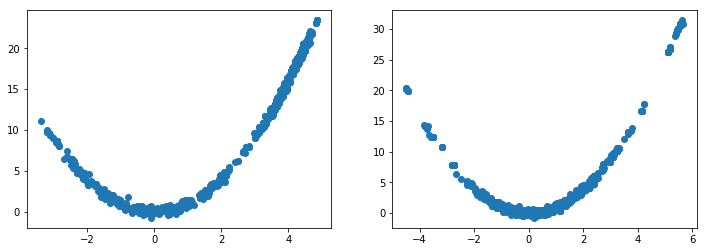

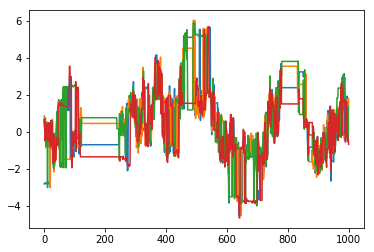

In [6]:
algorithms = ['MH', 'DEMC']
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
for i, algorithm in enumerate(algorithms):
    seed = prior_sample(nsamples=4)
    x = MCMC_v2(dimension=2, algorithm=algorithm, nburn=500, jump=10, nsamples=1000, seed=seed, 
                proposal_type='normal', proposal_scale=[1.,1.], concat_chains_=False,
                log_pdf_target=log_Rosenbrock)
    ax[i].plot(x.samples[:, 0, 0], x.samples[:, 0, 1], 'o')
plt.show()

## DRAM algorithm 

/Users/audreyolivier/Documents/JHU_Research/UQpy/src/UQpy/SampleMethods.py:2957: UserWarning: Input proposal_type not used in DE-MC algorithm (used inputs are "proposal_scale", "k0", "sp".
  warnings.warn('Input ' + key + ' not used in DE-MC algorithm (used inputs are "proposal_scale", "k0", '


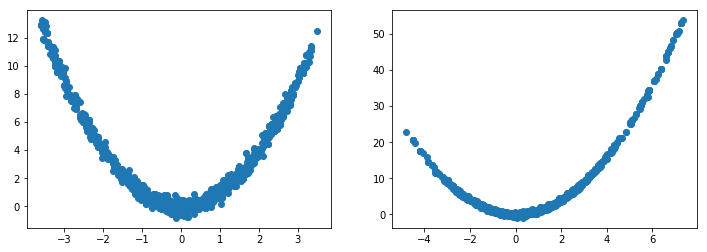

In [4]:
algorithms = ['MH', 'DRAM']
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
for i, algorithm in enumerate(algorithms):
    seed = prior_sample(nsamples=4)
    x = MCMC_v2(dimension=2, algorithm=algorithm, nburn=500, jump=10, nsamples=1000, seed=seed, 
                proposal_type='normal', proposal_scale=[1.,1.], concat_chains_=False,
                log_pdf_target=log_Rosenbrock)
    ax[i].plot(x.samples[:, 0, 0], x.samples[:, 0, 1], 'o')
plt.show()